# 제3장 파이썬을 이용한 GIS 데이터 분석
___
## 3.2 __GIS 데이터의 처리와 표현__


## __사전설정__
---

(1) 저장소 데이터 가져오기

In [ ]:
!rm -rf /content/BizDataAnalysis/

In [23]:
!git clone https://github.com/BizStat/BizDataAnalysis.git

Cloning into 'BizDataAnalysis'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 222 (delta 16), reused 40 (delta 8), pack-reused 174 (from 1)
Receiving objects: 100% (222/222), 124.71 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Updating files: 100% (40/40), done.



(2) matplotlib 환경에서 한글 사용

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -f -v
!rm ~/.cache/matplotlib -rf

런타임 메뉴에서 '세션 다시 시작' 후 다음의 명령문 실행

In [ ]:
from matplotlib import rc
rc('font', family='NanumMyeongjo')
rc('axes', unicode_minus=False)

___

## 수원시 지구대(파출소) 위치 나타내기

### open API를 이용해 데이터 가져오기

* 경기데이터드림에서 수원시 지구대(파출소) 현황 데이터 가져오기

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import requests as req
import json

* JSON 형식으로 결과 받기

In [2]:
uri = 'https://openapi.gg.go.kr/Ptrldvsnsubpolcstus'
params = {
  'KEY' : '32f6008628b644da80a3be1ae80cdae7',
  'Type' : 'json',
  'pIndex' : 1,
  'pSize'  : 100,
  'SIGUN_NM' : '수원시'
}
resp = req.get(uri,params=params)
tmp = json.loads(resp.content)

In [3]:
tmp

{'Ptrldvsnsubpolcstus': [{'head': [{'list_total_count': 23},
    {'RESULT': {'CODE': 'INFO-000', 'MESSAGE': '정상 처리되었습니다.'}},
    {'api_version': '1.0'}]},
  {'row': [{'SIGUN_NM': '수원시',
     'SIGUN_CD': '41110',
     'LOCAL_INST_NM': '경기남부청',
     'POLCSTTN_NM': '수원중부',
     'GOVOFC_NM': '장안문',
     'DIV_NM': '지구대',
     'DATA_STD_DE': '2018-10-17',
     'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 조원동 680-6번지',
     'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 송정로 113',
     'REFINE_ZIP_CD': '16308',
     'REFINE_WGS84_LOGT': '127.0095022415',
     'REFINE_WGS84_LAT': '37.2956796251'},
    {'SIGUN_NM': '수원시',
     'SIGUN_CD': '41110',
     'LOCAL_INST_NM': '경기남부청',
     'POLCSTTN_NM': '수원중부',
     'GOVOFC_NM': '노송',
     'DIV_NM': '지구대',
     'DATA_STD_DE': '2018-10-17',
     'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 파장동 566-14번지',
     'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 이목로 58',
     'REFINE_ZIP_CD': '16347',
     'REFINE_WGS84_LOGT': '126.9879468137',
     'REFINE_WGS84_LAT': '37.3103114869'},
    {'SIGUN_NM': 

In [4]:
resp

<Response [200]>

In [5]:
resp.content

b'{"Ptrldvsnsubpolcstus":[{"head":[{"list_total_count":23},{"RESULT":{"CODE":"INFO-000","MESSAGE":"\xec\xa0\x95\xec\x83\x81 \xec\xb2\x98\xeb\xa6\xac\xeb\x90\x98\xec\x97\x88\xec\x8a\xb5\xeb\x8b\x88\xeb\x8b\xa4."}},{"api_version":"1.0"}]},{"row":[{"SIGUN_NM":"\xec\x88\x98\xec\x9b\x90\xec\x8b\x9c","SIGUN_CD":"41110","LOCAL_INST_NM":"\xea\xb2\xbd\xea\xb8\xb0\xeb\x82\xa8\xeb\xb6\x80\xec\xb2\xad","POLCSTTN_NM":"\xec\x88\x98\xec\x9b\x90\xec\xa4\x91\xeb\xb6\x80","GOVOFC_NM":"\xec\x9e\xa5\xec\x95\x88\xeb\xac\xb8","DIV_NM":"\xec\xa7\x80\xea\xb5\xac\xeb\x8c\x80","DATA_STD_DE":"2018-10-17","REFINE_LOTNO_ADDR":"\xea\xb2\xbd\xea\xb8\xb0\xeb\x8f\x84 \xec\x88\x98\xec\x9b\x90\xec\x8b\x9c \xec\x9e\xa5\xec\x95\x88\xea\xb5\xac \xec\xa1\xb0\xec\x9b\x90\xeb\x8f\x99 680-6\xeb\xb2\x88\xec\xa7\x80","REFINE_ROADNM_ADDR":"\xea\xb2\xbd\xea\xb8\xb0\xeb\x8f\x84 \xec\x88\x98\xec\x9b\x90\xec\x8b\x9c \xec\x9e\xa5\xec\x95\x88\xea\xb5\xac \xec\x86\xa1\xec\xa0\x95\xeb\xa1\x9c 113","REFINE_ZIP_CD":"16308","REFINE_WGS84_LO

In [ ]:
resp

In [14]:
tmp

{'Ptrldvsnsubpolcstus': [{'head': [{'list_total_count': 23},
    {'RESULT': {'CODE': 'INFO-000', 'MESSAGE': '정상 처리되었습니다.'}},
    {'api_version': '1.0'}]},
  {'row': [{'SIGUN_NM': '수원시',
     'SIGUN_CD': '41110',
     'LOCAL_INST_NM': '경기남부청',
     'POLCSTTN_NM': '수원중부',
     'GOVOFC_NM': '장안문',
     'DIV_NM': '지구대',
     'DATA_STD_DE': '2018-10-17',
     'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 조원동 680-6번지',
     'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 송정로 113',
     'REFINE_ZIP_CD': '16308',
     'REFINE_WGS84_LOGT': '127.0095022415',
     'REFINE_WGS84_LAT': '37.2956796251'},
    {'SIGUN_NM': '수원시',
     'SIGUN_CD': '41110',
     'LOCAL_INST_NM': '경기남부청',
     'POLCSTTN_NM': '수원중부',
     'GOVOFC_NM': '노송',
     'DIV_NM': '지구대',
     'DATA_STD_DE': '2018-10-17',
     'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 파장동 566-14번지',
     'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 이목로 58',
     'REFINE_ZIP_CD': '16347',
     'REFINE_WGS84_LOGT': '126.9879468137',
     'REFINE_WGS84_LAT': '37.3103114869'},
    {'SIGUN_NM': 

In [15]:
tmp['Ptrldvsnsubpolcstus']

[{'head': [{'list_total_count': 23},
   {'RESULT': {'CODE': 'INFO-000', 'MESSAGE': '정상 처리되었습니다.'}},
   {'api_version': '1.0'}]},
 {'row': [{'SIGUN_NM': '수원시',
    'SIGUN_CD': '41110',
    'LOCAL_INST_NM': '경기남부청',
    'POLCSTTN_NM': '수원중부',
    'GOVOFC_NM': '장안문',
    'DIV_NM': '지구대',
    'DATA_STD_DE': '2018-10-17',
    'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 조원동 680-6번지',
    'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 송정로 113',
    'REFINE_ZIP_CD': '16308',
    'REFINE_WGS84_LOGT': '127.0095022415',
    'REFINE_WGS84_LAT': '37.2956796251'},
   {'SIGUN_NM': '수원시',
    'SIGUN_CD': '41110',
    'LOCAL_INST_NM': '경기남부청',
    'POLCSTTN_NM': '수원중부',
    'GOVOFC_NM': '노송',
    'DIV_NM': '지구대',
    'DATA_STD_DE': '2018-10-17',
    'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 파장동 566-14번지',
    'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 이목로 58',
    'REFINE_ZIP_CD': '16347',
    'REFINE_WGS84_LOGT': '126.9879468137',
    'REFINE_WGS84_LAT': '37.3103114869'},
   {'SIGUN_NM': '수원시',
    'SIGUN_CD': '41110',
    'LOCAL_INST_NM'

In [16]:
tmp['Ptrldvsnsubpolcstus'][0]

{'head': [{'list_total_count': 23},
  {'RESULT': {'CODE': 'INFO-000', 'MESSAGE': '정상 처리되었습니다.'}},
  {'api_version': '1.0'}]}

In [8]:
tmp['Ptrldvsnsubpolcstus'][1]['row']

[{'SIGUN_NM': '수원시',
  'SIGUN_CD': '41110',
  'LOCAL_INST_NM': '경기남부청',
  'POLCSTTN_NM': '수원중부',
  'GOVOFC_NM': '장안문',
  'DIV_NM': '지구대',
  'DATA_STD_DE': '2018-10-17',
  'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 조원동 680-6번지',
  'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 송정로 113',
  'REFINE_ZIP_CD': '16308',
  'REFINE_WGS84_LOGT': '127.0095022415',
  'REFINE_WGS84_LAT': '37.2956796251'},
 {'SIGUN_NM': '수원시',
  'SIGUN_CD': '41110',
  'LOCAL_INST_NM': '경기남부청',
  'POLCSTTN_NM': '수원중부',
  'GOVOFC_NM': '노송',
  'DIV_NM': '지구대',
  'DATA_STD_DE': '2018-10-17',
  'REFINE_LOTNO_ADDR': '경기도 수원시 장안구 파장동 566-14번지',
  'REFINE_ROADNM_ADDR': '경기도 수원시 장안구 이목로 58',
  'REFINE_ZIP_CD': '16347',
  'REFINE_WGS84_LOGT': '126.9879468137',
  'REFINE_WGS84_LAT': '37.3103114869'},
 {'SIGUN_NM': '수원시',
  'SIGUN_CD': '41110',
  'LOCAL_INST_NM': '경기남부청',
  'POLCSTTN_NM': '수원중부',
  'GOVOFC_NM': '화서문',
  'DIV_NM': '지구대',
  'DATA_STD_DE': '2018-10-17',
  'REFINE_LOTNO_ADDR': '경기도 수원시 팔달구 화서동 647-1번지',
  'REFINE_ROADNM_ADDR': '경기도 수원시

In [9]:
df1 = pd.json_normalize(tmp['Ptrldvsnsubpolcstus'][1]['row'])
df1.head()

,SIGUN_NM,SIGUN_CD,LOCAL_INST_NM,POLCSTTN_NM,GOVOFC_NM,DIV_NM,DATA_STD_DE,REFINE_LOTNO_ADDR,REFINE_ROADNM_ADDR,REFINE_ZIP_CD,REFINE_WGS84_LOGT,REFINE_WGS84_LAT
0,수원시,41110,경기남부청,수원중부,장안문,지구대,2018-10-17,경기도 수원시 장안구 조원동 680-6번지,경기도 수원시 장안구 송정로 113,16308,127.0095022415,37.2956796251
1,수원시,41110,경기남부청,수원중부,노송,지구대,2018-10-17,경기도 수원시 장안구 파장동 566-14번지,경기도 수원시 장안구 이목로 58,16347,126.9879468137,37.3103114869
2,수원시,41110,경기남부청,수원중부,화서문,지구대,2018-10-17,경기도 수원시 팔달구 화서동 647-1번지,경기도 수원시 팔달구 수성로182번길 3,16435,126.9931162592,37.2867051948
3,수원시,41110,경기남부청,수원중부,율천,파출소,2018-10-17,경기도 수원시 장안구 율전동 497-7번지,경기도 수원시 장안구 서부로 2124,16417,126.9716180367,37.2979012089
4,수원시,41110,경기남부청,수원중부,창룡문,파출소,2018-10-17,경기도 수원시 장안구 연무동 254-11번지,경기도 수원시 장안구 경수대로 758,16221,127.0218957472,37.2910109750


In [10]:
df1.columns

Index(['SIGUN_NM', 'SIGUN_CD', 'LOCAL_INST_NM', 'POLCSTTN_NM', 'GOVOFC_NM',
       'DIV_NM', 'DATA_STD_DE', 'REFINE_LOTNO_ADDR', 'REFINE_ROADNM_ADDR',
       'REFINE_ZIP_CD', 'REFINE_WGS84_LOGT', 'REFINE_WGS84_LAT'],
      dtype='object')

In [11]:
df1.dtypes

,0
SIGUN_NM,object
SIGUN_CD,object
LOCAL_INST_NM,object
POLCSTTN_NM,object
GOVOFC_NM,object
DIV_NM,object
DATA_STD_DE,object
REFINE_LOTNO_ADDR,object
REFINE_ROADNM_ADDR,object
REFINE_ZIP_CD,object


* 필요한 정보만 추출

In [12]:
sw_ps = df1[['SIGUN_CD','GOVOFC_NM','DIV_NM','REFINE_WGS84_LOGT','REFINE_WGS84_LAT']]

In [13]:
sw_ps.head()


,SIGUN_CD,GOVOFC_NM,DIV_NM,REFINE_WGS84_LOGT,REFINE_WGS84_LAT
0,41110,장안문,지구대,127.0095022415,37.2956796251
1,41110,노송,지구대,126.9879468137,37.3103114869
2,41110,화서문,지구대,126.9931162592,37.2867051948
3,41110,율천,파출소,126.9716180367,37.2979012089
4,41110,창룡문,파출소,127.0218957472,37.2910109750


* 위도(LAT)와 경도(LOGT) 좌표를 이용해 공간 정보(점) 생성

In [18]:
sw_ps['REFINE_WGS84_LOGT'] = sw_ps['REFINE_WGS84_LOGT'].astype(float)
sw_ps['REFINE_WGS84_LAT'] = sw_ps['REFINE_WGS84_LAT'].astype(float)

<ipython-input-18-8af5bb9b8d17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sw_ps['REFINE_WGS84_LOGT'] = sw_ps['REFINE_WGS84_LOGT'].astype(float)
<ipython-input-18-8af5bb9b8d17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sw_ps['REFINE_WGS84_LAT'] = sw_ps['REFINE_WGS84_LAT'].astype(float)


In [19]:
sw_ps['geom'] = sw_ps.apply(lambda x : Point([x['REFINE_WGS84_LOGT'],x['REFINE_WGS84_LAT']]),axis=1)
sw_ps.head()

<ipython-input-19-e181a80d793c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sw_ps['geom'] = sw_ps.apply(lambda x : Point([x['REFINE_WGS84_LOGT'],x['REFINE_WGS84_LAT']]),axis=1)


,SIGUN_CD,GOVOFC_NM,DIV_NM,REFINE_WGS84_LOGT,REFINE_WGS84_LAT,geom
0,41110,장안문,지구대,127.009502,37.295680,POINT (127.0095022415 37.2956796251)
1,41110,노송,지구대,126.987947,37.310311,POINT (126.9879468137 37.3103114869)
2,41110,화서문,지구대,126.993116,37.286705,POINT (126.9931162592 37.2867051948)
3,41110,율천,파출소,126.971618,37.297901,POINT (126.9716180367 37.2979012089)
4,41110,창룡문,파출소,127.021896,37.291011,POINT (127.0218957472 37.291010975)


In [20]:
sw_ps = gpd.GeoDataFrame(sw_ps,geometry='geom')
sw_ps.head()

,SIGUN_CD,GOVOFC_NM,DIV_NM,REFINE_WGS84_LOGT,REFINE_WGS84_LAT,geom
0,41110,장안문,지구대,127.009502,37.295680,POINT (127.0095 37.29568)
1,41110,노송,지구대,126.987947,37.310311,POINT (126.98795 37.31031)
2,41110,화서문,지구대,126.993116,37.286705,POINT (126.99312 37.28671)
3,41110,율천,파출소,126.971618,37.297901,POINT (126.97162 37.2979)
4,41110,창룡문,파출소,127.021896,37.291011,POINT (127.0219 37.29101)


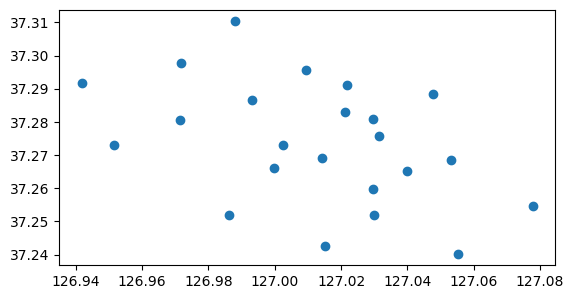

In [21]:
sw_ps.plot()
plt.show()

In [ ]:
sw_ps.plot(marker='^',color='black')
plt.show()

* 수원시 지도 데이터 가져오기

In [24]:
emd = gpd.read_file('/content/BizDataAnalysis/DATA/emd.shp',encoding='CP949')
emd.head()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((953700.022 1954605.065, 953693.871 1..."
1,11110102,Singyo-dong,신교동,"POLYGON ((953233.465 1953996.984, 953235.183 1..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((953560.228 1954257.466, 953561.19 19..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((953519.843 1953890.785, 953518.489 1..."
4,11110105,Changseong-dong,창성동,"POLYGON ((953516.123 1953734.362, 953516.526 1..."


* 수원시 추출

In [25]:
suwon = emd[emd['EMD_CD'].apply(lambda x : x.startswith('4111'))]

In [26]:
seoul = emd[emd['EMD_CD'].apply(lambda x : x.startswith('11'))]

<Axes: >

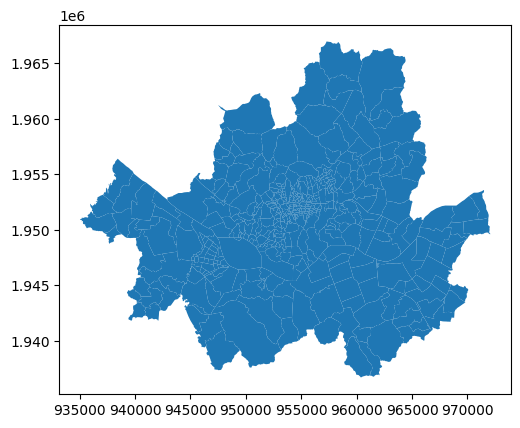

In [27]:
seoul.plot()

In [ ]:
suwon.head()

<Axes: >

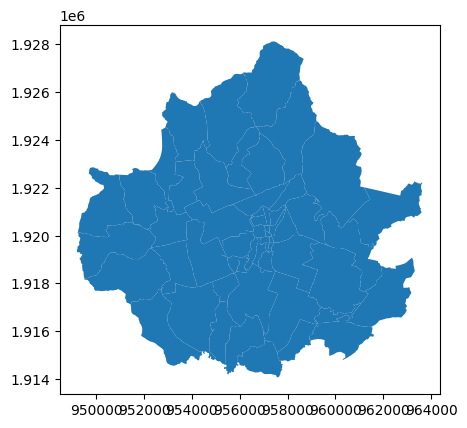

In [28]:
suwon.plot()

In [ ]:
suwon.plot(column='EMD_KOR_NM',figsize=(8,8),cmap='coolwarm',alpha=0.7)

* 서울시 행정구역 지도 표현

In [ ]:
seoul = emd[emd['EMD_CD'].apply(lambda x : x.startswith('11'))]
seoul.plot()

* 좌표계 확인 및 지정

In [29]:
suwon.crs

<Projected CRS: PROJCS["PCS_ITRF2000_TM",GEOGCS["ITRF2000",DATUM[" ...>
Name: PCS_ITRF2000_TM
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: International Terrestrial Reference Frame 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
sw_ps.crs

In [31]:
suwon = suwon.to_crs({'init':'epsg:4326'})

/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [32]:
suwon.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

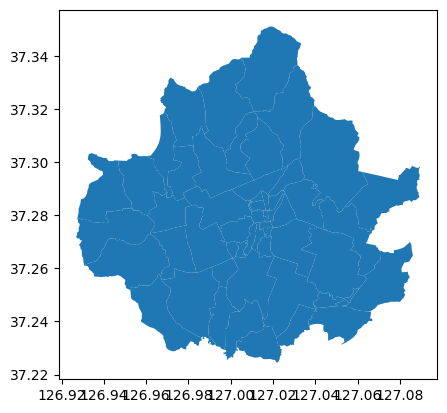

In [33]:
suwon.plot()

In [ ]:
sw_ps.crs

In [ ]:
sw_ps.crs = {'init':'epsg:4326'}
sw_ps.crs

In [ ]:
sw_ps.plot()

In [ ]:
fig, ax = plt.subplots(facecolor='white',figsize=(8,8))
ax.axis('off')
ax.set_title("수원시 지구대(파출소) 현황", fontsize=20)
suwon.plot(ax=ax,column='EMD_KOR_NM',cmap='coolwarm',alpha=0.7)
sw_ps.plot(ax=ax,marker='o',color='black',label='지구대(파출소)')
plt.legend()
plt.show()

* 구글 드라이브에 수원시 행정구역 지도 데이터와 지구대(파출소) 위치 데이터 저장

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
suwon.to_file('/content/drive/MyDrive/BizDataAnalysis/DATA/suwon.shp',driver='ESRI Shapefile',encoding='cp949')

In [ ]:
sw_ps.to_file('/content/drive/MyDrive/BizDataAnalysis/DATA/sw_ps.shp',driver='ESRI Shapefile',encoding='cp949')